In [ ]:
!pip install pycolmap

In [ ]:
!pip install open3d

In [ ]:
import numpy as np
import cv2 as cv
import glob
import pycolmap
import open3d as o3d
import shutil

from google.colab.patches import cv2_imshow
import os
import matplotlib.pyplot as plt

Cargar las imagenes.

In [102]:
chessboardSize = (7,7)

frameSize = (358, 268)

In [103]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [104]:
objp = np.zeros((chessboardSize[0]*chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0], 0:chessboardSize[1]].T.reshape(-1, 2)

In [105]:
objPoints = []
imgPoints = []

In [106]:
chess = glob.glob('chess/*.jpeg')

In [107]:
for image in chess:
    img = cv.imread(image)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #Detectar esquinas del tablero
    ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)

    if ret == True:
        objPoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgPoints.append(corners)

        # Dibujar las esquinas detectadas
        cv.drawChessboardCorners(img, chessboardSize, corners2, ret)
        #cv.imshow("Chessboard", img)
        #cv2_imshow(img)
        cv.waitKey(1000)

cv.destroyAllWindows()

In [108]:
#Calibración
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objPoints, imgPoints, gray.shape[::-1], None, None)

#Guardar parámetros de calibración
np.savez("calibration_data.npz", mtx=mtx, dist=dist)

In [109]:
#Cargar los parámetros de calibración
calib_data = np.load("calibration_data.npz")
mtx = calib_data["mtx"]
dist = calib_data["dist"]

In [128]:
#Cargar las imagenes del cubo
#cubo = glob.glob('cubo/*.jpeg')
cubo = glob.glob('cubo2/*.jpeg')

Escala de grises. Contraste. Reducción de ruido.

In [129]:
#Inicializar SIFT
sift = cv.SIFT_create()

keypoints_list = []
descriptors_list = []
loaded_images = []

cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM (3).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.31 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.32 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.32 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.31 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.28 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.34 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.29 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.32 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.33 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM (2).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.31 PM (1).jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.29 PM.jpeg
cubo2/WhatsApp Image 2025-02-23 at 10.33.30 PM (3).jpeg


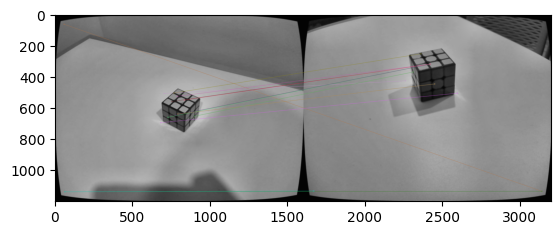

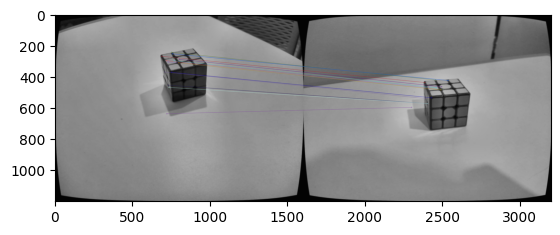

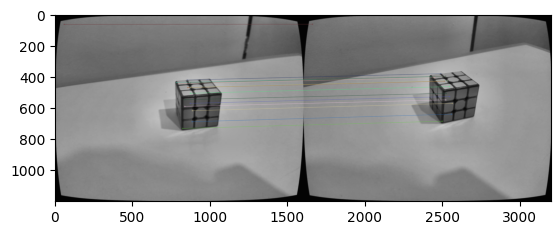

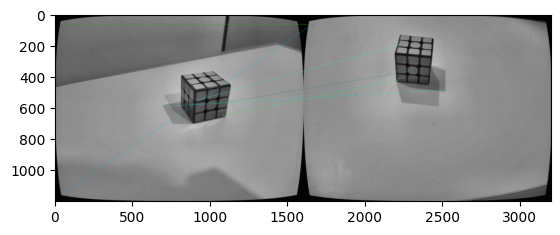

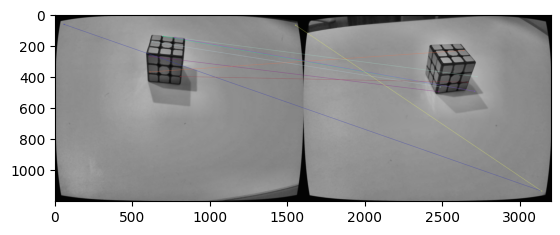

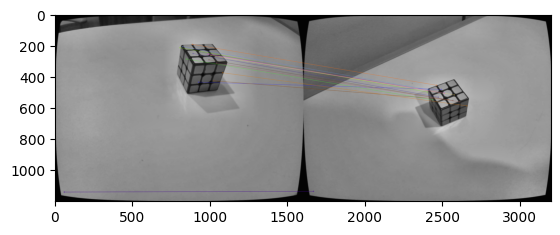

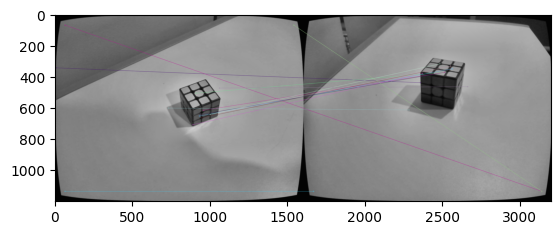

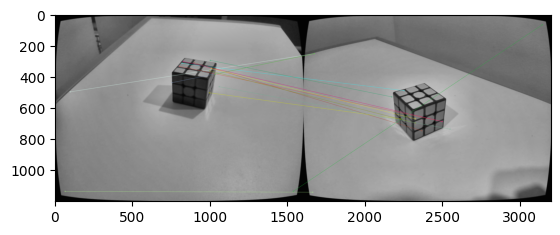

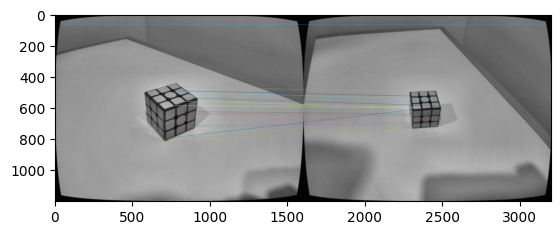

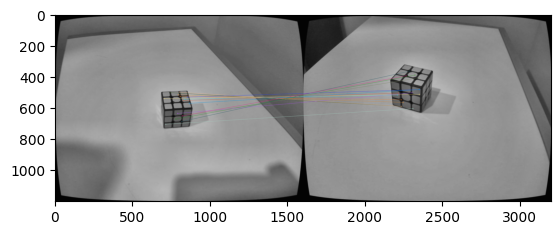

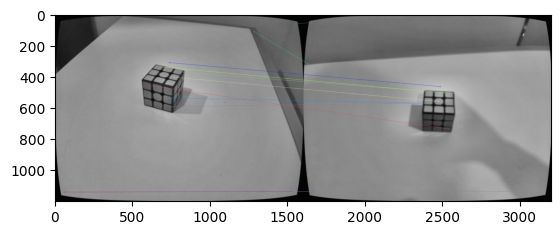

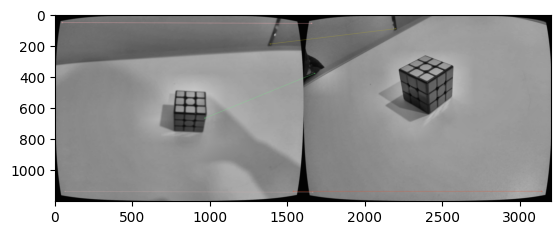

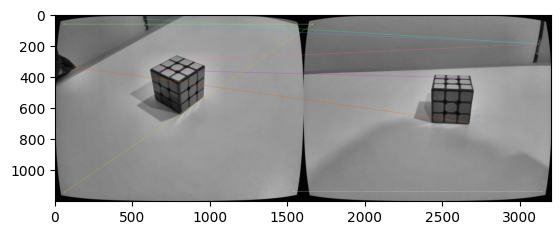

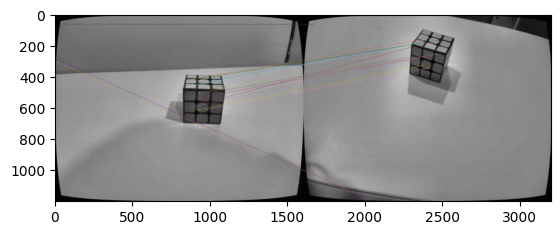

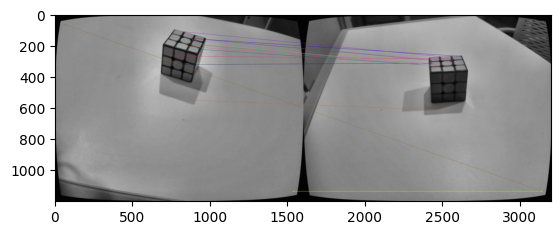

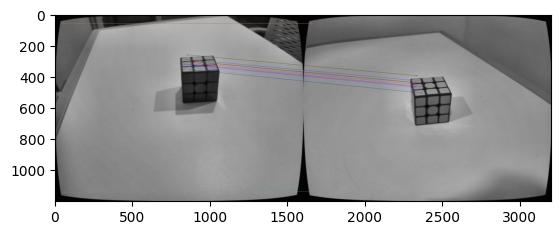

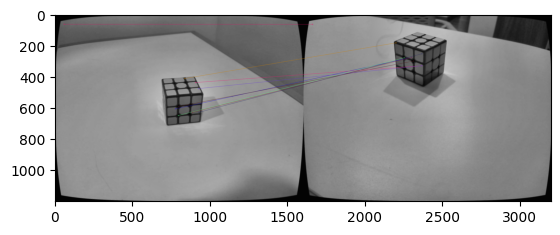

In [130]:
for image in cubo:
    print(image)
    img = cv.imread(image)
    h, w = img.shape[:2]

    #Corregir distorsión
    new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undistorted = cv.undistort(img, mtx, dist, None, new_camera_mtx)

    #Escala de grises
    gray = cv.cvtColor(undistorted, cv.COLOR_BGR2GRAY)

    #Mejoras de contraste
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    #Reducción de ruido
    denoised = cv.bilateralFilter(cl1, d=9, sigmaColor=75, sigmaSpace=75)

    #Detectar las esquinas
    dst = cv.cornerHarris(denoised, 2, 3, 0.04)

    dst = cv.dilate(dst, None)

    #Seleccionar las esquinas más destacadas
    corners = np.argwhere(dst > 0.01 * dst.max())

    if len(corners) >= 9:  # Si se detectan al menos 9 puntos
        #Dibujar esquinas detectadas
        for x, y in corners[:9]:
            cv.circle(undistorted, (y, x), 5, (0, 255, 0), -1)

    #Aplicar SIFT sobre la imagen
    keypoints, descriptors = sift.detectAndCompute(denoised, None)

    #Guardar resultados
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    loaded_images.append(denoised)

# Emparejamiento de características con FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)

for i in range(len(loaded_images) - 1):
    img1, img2 = loaded_images[i], loaded_images[i + 1]
    kp1, kp2 = keypoints_list[i], keypoints_list[i + 1]
    des1, des2 = descriptors_list[i], descriptors_list[i + 1]

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # Dibujar los mejores 20 emparejamientos
    img_matches = cv.drawMatches(img1, kp1, img2, kp2, good_matches[:15], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #cv2_imshow(img_matches)
    #cv.waitKey(500)
    plt.imshow(img_matches)
    plt.show()

cv.destroyAllWindows()

Estimación de la matriz fundamental y la matriz escencial.

In [131]:
#Listas para almacenar puntos emparejados
pts1 = []
pts2 = []

for i in range(len(loaded_images) - 1):
    kp1, kp2 = keypoints_list[i], keypoints_list[i + 1]
    #matches = bf.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)
    matches = flann.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    #Extraer coordenadas de los puntos clave emparejados
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    #Guardar los puntos de correspondencia
    pts1.append(src_pts)
    pts2.append(dst_pts)

pts1 = np.concatenate(pts1)
pts2 = np.concatenate(pts2)

#Calcular la matriz fundamental
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

In [132]:
#Calcular la matriz esencial
E = mtx.T @ F @ mtx

In [133]:
#Descomposición de la Matriz Escencial
_, R, t, mask = cv.recoverPose(E, pts1, pts2, mtx)

In [134]:
#Construcción de las matrices de Proyección.
P1 = mtx @ np.hstack((np.eye(3), np.zeros((3,1))))  # [I | 0]
P2 = mtx @ np.hstack((R, t))  # [R | t]

In [135]:
#Triangulación para obtener los puntos 3D
points_4D = cv.triangulatePoints(P1, P2, pts1.T, pts2.T)

points_3D = points_4D[:3] / points_4D[3]

In [136]:
print("Matriz Fundamental (F):\n", F)
print("\nMatriz Esencial (E):\n", E)
print("\nMatriz de Rotación (R):\n", R)
print("\nVector de Traslación (t):\n", t)
print("\nPuntos 3D reconstruidos:\n", points_3D.T)

Matriz Fundamental (F):
 [[ 4.24099305e-07 -4.08207591e-05 -3.59187071e-02]
 [ 4.83209739e-05  6.44625107e-06 -3.66366235e-02]
 [ 2.69090458e-02  2.81666730e-02  1.00000000e+00]]

Matriz Esencial (E):
 [[  0.66094953 -63.52544511 -75.49269251]
 [ 75.1973125   10.01704811   6.78633064]
 [ 70.78980933  -0.16443402  -5.00644065]]

Matriz de Rotación (R):
 [[ 0.98778505  0.1370933  -0.07406838]
 [-0.12765155  0.98454317  0.11991589]
 [ 0.08936319 -0.10899618  0.9900172 ]]

Vector de Traslación (t):
 [[-0.10923264]
 [-0.68083543]
 [ 0.72424537]]

Puntos 3D reconstruidos:
 [[ 1.91688225e-01  5.64803958e-01 -6.87270463e-01]
 [ 2.27180555e-01  4.49732572e-01 -4.16279852e-01]
 [-2.42169380e+00  1.76850724e+00  4.15815163e+00]
 [ 3.03349674e-01  1.97667003e-01  2.65232635e+00]
 [-1.21121973e-01 -2.39341438e-01  2.96646285e+00]
 [ 8.64249840e-02  7.06917569e-02  1.29003680e+00]
 [ 1.20955795e-01 -5.72725050e-02  1.67162812e+00]
 [ 7.33861998e-02 -1.18473478e-01  1.47305858e+00]
 [ 1.16829328e-01 

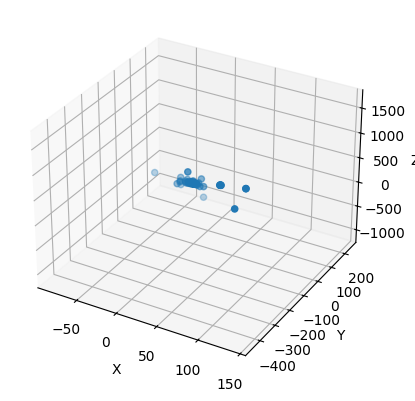

In [137]:
#Graficar en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[0], points_3D[1], points_3D[2], marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()